# Week 3: XGBoost Modeling and SHAP Interpretation

## Objectives
1. Load preprocessed data and baseline model
2. Train XGBoost classifier with class imbalance handling
3. Perform hyperparameter tuning
4. Evaluate and compare with baseline
5. Use SHAP for model interpretation

In this notebook, we upgrade our hit-prediction pipeline from a logistic regression baseline to a tuned XGBoost model and then interpret it with SHAP. We load the same preprocessed Spotify dataset (113,999 songs, 9 audio features), keep the same train–test split as before, and handle the 52:1 class imbalance using scale_pos_weight so hits get more weight. We first train a default XGBoost model, then run RandomizedSearchCV to tune key hyperparameters, retrain the best model with an internal validation split and early stopping, and evaluate it on the held-out test set. We compare XGBoost directly to logistic regression using multiple metrics, plot a confusion matrix and model-comparison charts, and then run a full SHAP analysis to compute feature importance, generate summary and dependence plots, explain an example hit prediction, and finally save the trained model, metrics, SHAP values, and figures.


---

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
from tqdm.auto import tqdm

# Machine learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import xgboost as xgb
import shap

# Settings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print(" Libraries imported successfully")

 Libraries imported successfully


In [2]:
# Configuration
# Set this to True to skip hyperparameter tuning (faster, uses defaults)
# Set to False for full hyperparameter search (slower, better results)
SKIP_TUNING = False  # Change to True for quick testing

if SKIP_TUNING:
    print("  QUICK MODE: Skipping hyperparameter tuning")
    print("   Will use default parameters (faster but may not be optimal)")
else:
    print("  FULL MODE: Will perform hyperparameter tuning")
    print("   This may take 15-30 minutes depending on dataset size")

  FULL MODE: Will perform hyperparameter tuning
   This may take 15-30 minutes depending on dataset size


In [3]:
# Set up paths
project_root = Path.cwd().parent
data_dir = project_root / 'data'
processed_data_dir = data_dir / 'processed'
models_dir = project_root / 'models'
figures_dir = project_root / 'figures'

print(f"Project root: {project_root}")
print(f"Models directory: {models_dir}")

Project root: c:\Users\aruni\FeatureBeats
Models directory: c:\Users\aruni\FeatureBeats\models


## 1. Load Data and Baseline Model

In [4]:
# Load dataset
data_file = processed_data_dir / 'hits_dataset.csv'

if not data_file.exists():
    raise FileNotFoundError(
        f" Dataset not found. Please run notebooks 01 and 02 first!"
    )

df = pd.read_csv(data_file)
print(f" Loaded dataset: {df.shape}")
print(f"\nClass distribution:")
print(df['is_hit'].value_counts())

 Loaded dataset: (113999, 13)

Class distribution:
is_hit
0    111861
1      2138
Name: count, dtype: int64


In [5]:
# Prepare features and target (same as Week 2)
exclude_cols = ['is_hit', 'year']
text_cols = df.select_dtypes(include=['object']).columns.tolist()
exclude_cols.extend(text_cols)

feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols].values
y = df['is_hit'].values

print(f"Features: {feature_cols}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
X shape: (113999, 9)
y shape: (113999,)


In [6]:
# Split data (same split as Week 2 for fair comparison)
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED,
    stratify=y
)

print(f"Train set: {len(X_train):,} samples")
print(f"Test set:  {len(X_test):,} samples")

Train set: 91,199 samples
Test set:  22,800 samples


In [7]:
# Load baseline model for comparison
baseline_file = models_dir / 'baseline_logreg.pkl'
if baseline_file.exists():
    baseline_model = joblib.load(baseline_file)
    baseline_metrics = pd.read_csv(models_dir / 'baseline_metrics.csv')
    print(" Loaded baseline model")
    print("\nBaseline performance:")
    print(baseline_metrics.to_string(index=False))
else:
    print("  Baseline model not found. Run notebook 02 first for comparison.")
    baseline_model = None
    baseline_metrics = None

 Loaded baseline model

Baseline performance:
              model  accuracy  precision  recall  f1_score  roc_auc   pr_auc
Logistic Regression  0.619781   0.039352 0.82243  0.075109  0.76879 0.054631


## 2. XGBoost with Default Parameters

First, we train XGBoost with reasonable default parameters to establish a quick baseline.

In [8]:
# Calculate scale_pos_weight for class imbalance
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

print(f"Class imbalance handling:")
print(f"  Negative samples: {neg_count:,}")
print(f"  Positive samples: {pos_count:,}")
print(f"  scale_pos_weight: {scale_pos_weight:.2f}")
print(f"\n  This parameter tells XGBoost to give {scale_pos_weight:.1f}x more weight to hits.")

Class imbalance handling:
  Negative samples: 89,489
  Positive samples: 1,710
  scale_pos_weight: 52.33

  This parameter tells XGBoost to give 52.3x more weight to hits.


In [9]:
# Train XGBoost with default parameters
print("Training XGBoost with default parameters...\n")

xgb_default = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_SEED,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss'
)

xgb_default.fit(X_train, y_train)

# Evaluate
y_pred_default = xgb_default.predict(X_test)
y_pred_proba_default = xgb_default.predict_proba(X_test)[:, 1]

print(" Default XGBoost trained")
print(f"\nQuick Performance Check:")
print(f"  Accuracy:  {accuracy_score(y_test, y_pred_default):.4f}")
print(f"  Precision: {precision_score(y_test, y_pred_default):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_default):.4f}")
print(f"  F1 Score:  {f1_score(y_test, y_pred_default):.4f}")

Training XGBoost with default parameters...

 Default XGBoost trained

Quick Performance Check:
  Accuracy:  0.8398
  Precision: 0.0913
  Recall:    0.8411
  F1 Score:  0.1647


## 3. Hyperparameter Tuning 

Use RandomizedSearchCV to find better hyperparameters.

In [11]:
if not SKIP_TUNING:
    print("Starting hyperparameter tuning...")
    
    # Define parameter grid
    param_distributions = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3],
    }
    
    # Base model
    xgb_base = xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_SEED,
        eval_metric='logloss'
    )
    
    # Randomized search
    random_search = RandomizedSearchCV(
        xgb_base,
        param_distributions=param_distributions,
        n_iter=20,  # Number of parameter combinations to try
        cv=3,  # 3-fold cross-validation
        scoring='f1',  # Optimize for F1 score (good for imbalanced data)
        random_state=RANDOM_SEED,
        n_jobs=-1,  # Use all CPU cores
        verbose=1
    )
    
    # Fit
    random_search.fit(X_train, y_train)
    
    print("\n Hyperparameter tuning complete!")
    print(f"\nBest parameters:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    print(f"\nBest cross-validation F1 score: {random_search.best_score_:.4f}")
    
    # Use best model
    xgb_final = random_search.best_estimator_
    
else:
    print("  Skipping hyperparameter tuning (using default parameters)")
    xgb_final = xgb_default

Starting hyperparameter tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

 Hyperparameter tuning complete!

Best parameters:
  subsample: 0.9
  n_estimators: 200
  min_child_weight: 5
  max_depth: 7
  learning_rate: 0.2
  gamma: 0.2
  colsample_bytree: 0.9

Best cross-validation F1 score: 0.7632


## 4. Final Model Training with Early Stopping

In [12]:
# Train final model with early stopping to prevent overfitting
print("Training final XGBoost model with early stopping...\n")

# Split training data into train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y_train
)

# Train with early stopping
xgb_final.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print(" Final model trained")

Training final XGBoost model with early stopping...

 Final model trained


## 5. Model Evaluation

In [13]:
# Make predictions
y_pred = xgb_final.predict(X_test)
y_pred_proba = xgb_final.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)

print("XGBOOST RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")
print(f"PR-AUC:    {pr_auc:.4f}")

# Compare with baseline
if baseline_metrics is not None:
    print("\n" + "="*60)
    print("COMPARISON WITH BASELINE")
    print("="*60)
    
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC', 'PR-AUC'],
        'Logistic Regression': [
            baseline_metrics['accuracy'].values[0],
            baseline_metrics['precision'].values[0],
            baseline_metrics['recall'].values[0],
            baseline_metrics['f1_score'].values[0],
            baseline_metrics['roc_auc'].values[0],
            baseline_metrics['pr_auc'].values[0]
        ],
        'XGBoost': [accuracy, precision, recall, f1, roc_auc, pr_auc]
    })
    
    comparison['Improvement'] = comparison['XGBoost'] - comparison['Logistic Regression']
    comparison['Improvement %'] = (comparison['Improvement'] / comparison['Logistic Regression'] * 100).round(1)
    
    print(comparison.to_string(index=False))

XGBOOST RESULTS
Accuracy:  0.9911
Precision: 0.7718
Recall:    0.7430
F1 Score:  0.7571
ROC-AUC:   0.9420
PR-AUC:    0.7818

COMPARISON WITH BASELINE
   Metric  Logistic Regression  XGBoost  Improvement  Improvement %
 Accuracy             0.619781 0.991053     0.371272           59.9
Precision             0.039352 0.771845     0.732493         1861.4
   Recall             0.822430 0.742991    -0.079439           -9.7
 F1 Score             0.075109 0.757143     0.682034          908.1
  ROC-AUC             0.768790 0.941990     0.173200           22.5
   PR-AUC             0.054631 0.781838     0.727207         1331.1


### Confusion Matrix

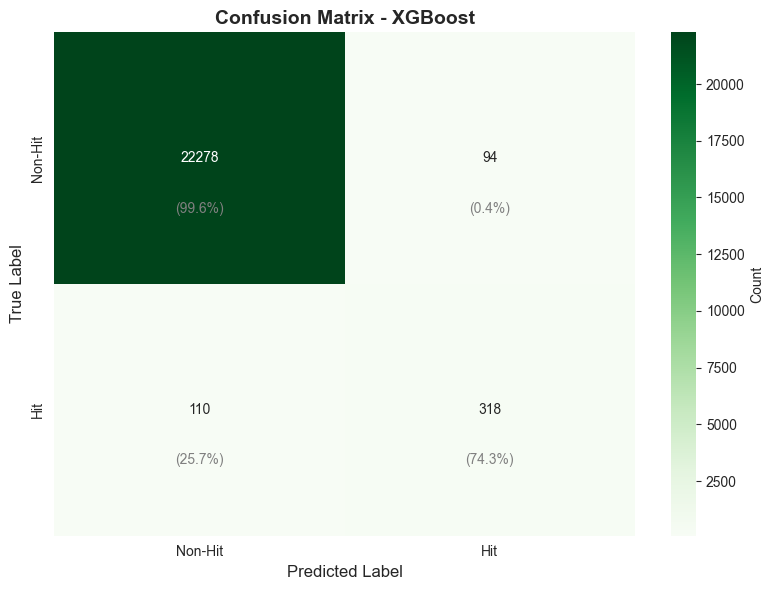

 Saved: xgboost_confusion_matrix.png


In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Non-Hit', 'Hit'],
            yticklabels=['Non-Hit', 'Hit'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - XGBoost', fontsize=14, fontweight='bold')

# percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.savefig(figures_dir / 'xgboost_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: xgboost_confusion_matrix.png")

### Classification Report

In [15]:
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred, 
                          target_names=['Non-Hit', 'Hit'],
                          digits=4))

Classification Report:
              precision    recall  f1-score   support

     Non-Hit     0.9951    0.9958    0.9954     22372
         Hit     0.7718    0.7430    0.7571       428

    accuracy                         0.9911     22800
   macro avg     0.8835    0.8694    0.8763     22800
weighted avg     0.9909    0.9911    0.9910     22800



## 6. Model Comparison Visualization

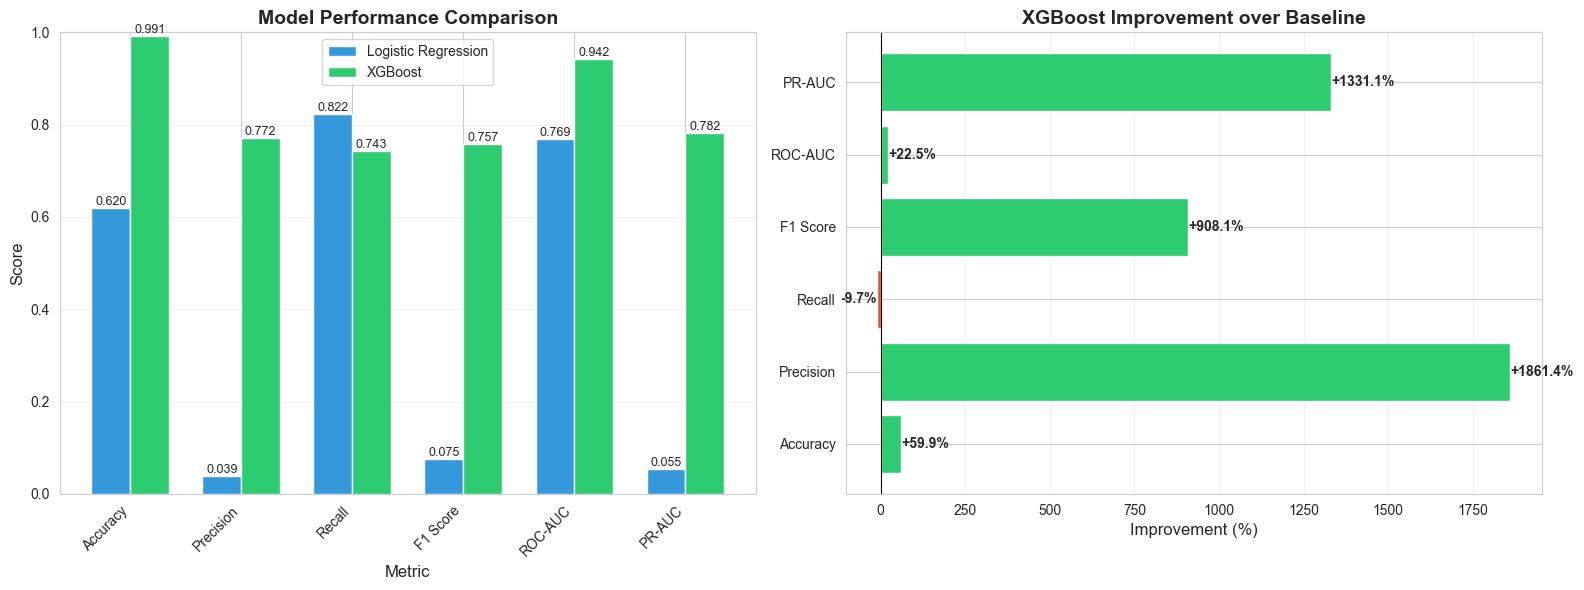

Saved: model_comparison.png


In [16]:
if baseline_metrics is not None:
    # Side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Metrics comparison bar chart
    ax1 = axes[0]
    x = np.arange(len(comparison['Metric']))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, comparison['Logistic Regression'], width, 
                    label='Logistic Regression', color='#3498db')
    bars2 = ax1.bar(x + width/2, comparison['XGBoost'], width,
                    label='XGBoost', color='#2ecc71')
    
    ax1.set_xlabel('Metric', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(comparison['Metric'], rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Improvement visualization
    ax2 = axes[1]
    colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in comparison['Improvement %']]
    bars = ax2.barh(comparison['Metric'], comparison['Improvement %'], color=colors)
    
    ax2.set_xlabel('Improvement (%)', fontsize=12)
    ax2.set_title('XGBoost Improvement over Baseline', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        label_x = width + (1 if width > 0 else -1)
        ax2.text(label_x, bar.get_y() + bar.get_height()/2.,
                f'{width:+.1f}%', ha='left' if width > 0 else 'right', 
                va='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(figures_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: model_comparison.png")

## 7. SHAP Analysis for Model Interpretation

Through SHAP (SHapley Additive exPlanations) we understand:
- Which features are most important
- How each feature affects predictions
- Individual prediction explanations

In [17]:
print("Calculating SHAP values...")


# Create SHAP explainer
# a sample for faster computation if dataset is large
sample_size = len(X_test)
X_test_sample = X_test[:sample_size]
y_test_sample = y_test[:sample_size]

explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_test_sample)

print(f" SHAP values calculated for {sample_size} samples")

Calculating SHAP values...
 SHAP values calculated for 22800 samples


### SHAP Feature Importance

SHAP Feature Importance:
loudness             1.1187
acousticness         0.8968
instrumentalness     0.8613
valence              0.8171
energy               0.8111
speechiness          0.8050
liveness             0.7895
danceability         0.7701
tempo                0.7222


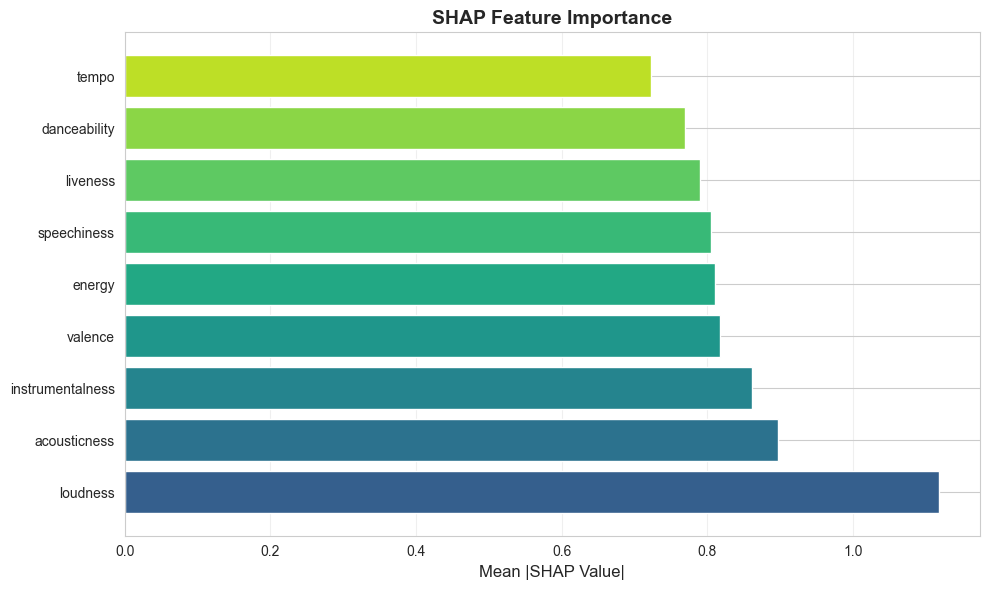

 Saved: shap_feature_importance.png


In [18]:
# Feature importance based on mean absolute SHAP values
shap_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values('Importance', ascending=False)

print("SHAP Feature Importance:")
print("="*60)
for idx, row in shap_importance.iterrows():
    print(f"{row['Feature']:20s} {row['Importance']:.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(shap_importance)))
bars = ax.barh(range(len(shap_importance)), shap_importance['Importance'], color=colors)

ax.set_yticks(range(len(shap_importance)))
ax.set_yticklabels(shap_importance['Feature'])
ax.set_xlabel('Mean |SHAP Value|', fontsize=12)
ax.set_title('SHAP Feature Importance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(figures_dir / 'shap_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Saved: shap_feature_importance.png")

### SHAP Summary Plot

Shows both feature importance and effect direction.

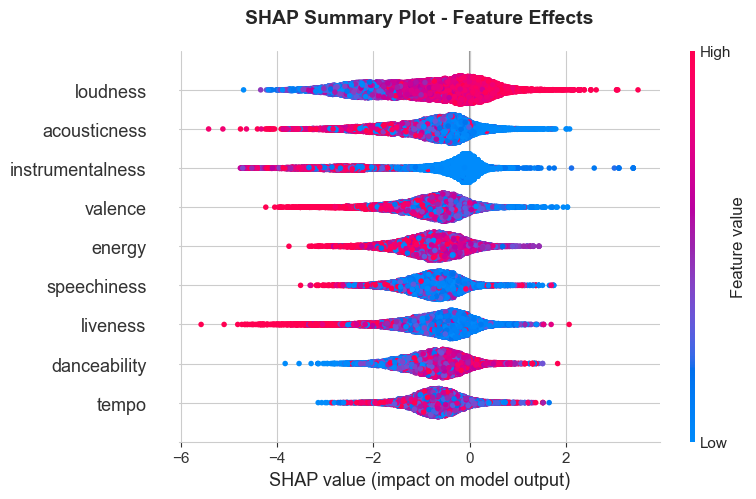

Saved: shap_summary_detailed.png


In [20]:
# Summary plot (beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, 
                  feature_names=feature_cols,
                  show=False)
plt.title('SHAP Summary Plot - Feature Effects', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(figures_dir / 'shap_summary_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: shap_summary_detailed.png")

In this plot:
  
  Each dot is a song
  
  Red = high feature value, Blue = low feature value
  
  Right side (positive SHAP) = increases hit probability
  
  Left side (negative SHAP) = decreases hit probability

### SHAP Dependence Plots

This shows how individual features affect predictions.

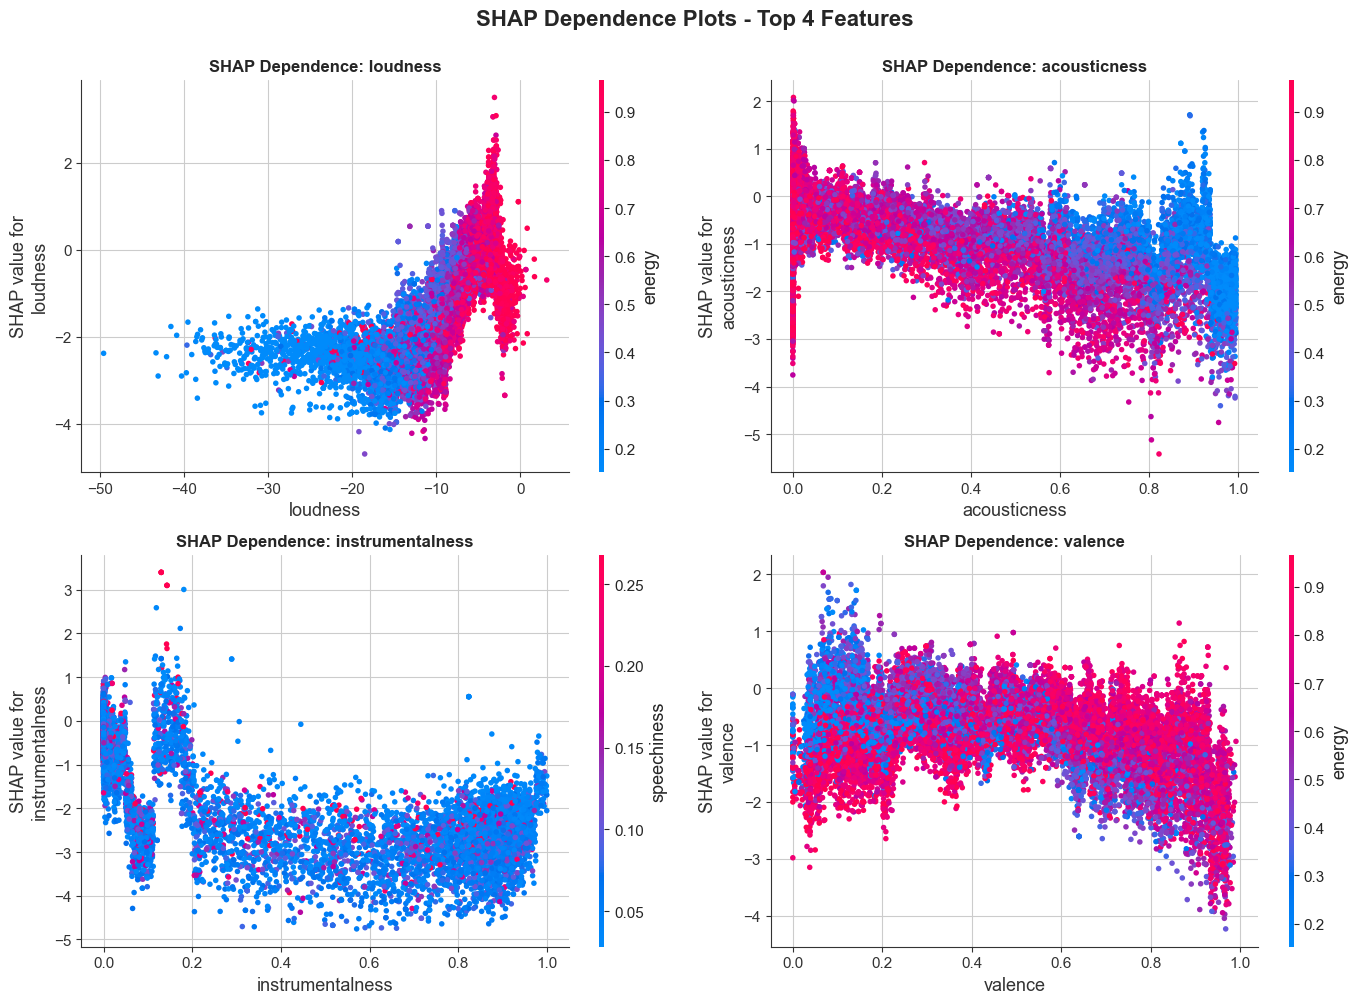

Saved: shap_dependence_plots.png


In [21]:
# Create dependence plots for top 4 features
top_features = shap_importance['Feature'].head(4).tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    feature_idx = feature_cols.index(feature)
    shap.dependence_plot(
        feature_idx, 
        shap_values, 
        X_test_sample,
        feature_names=feature_cols,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence: {feature}', fontweight='bold')

plt.suptitle('SHAP Dependence Plots - Top 4 Features', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(figures_dir / 'shap_dependence_plots.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: shap_dependence_plots.png")

### SHAP Force Plot (Sample Prediction Explanation)

Explaining prediction for sample 14 (actual HIT)
Predicted probability: 0.9957


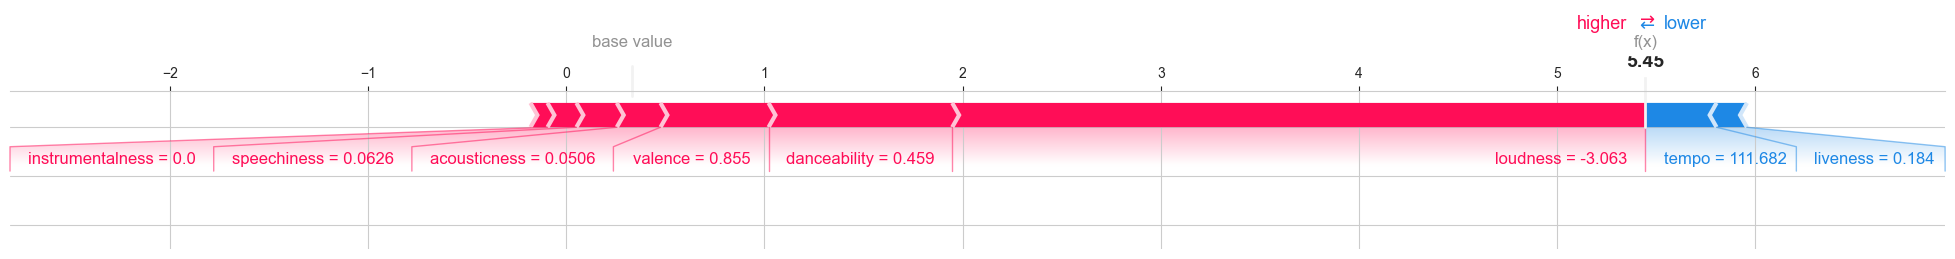

Saved: shap_force_plot_example.png


In [22]:
# Explain a single hit song prediction
hit_indices = np.where(y_test_sample == 1)[0]
if len(hit_indices) > 0:
    sample_idx = hit_indices[0]  # First hit in test set
    
    print(f"Explaining prediction for sample {sample_idx} (actual HIT)")
    print(f"Predicted probability: {xgb_final.predict_proba(X_test_sample[sample_idx:sample_idx+1])[:, 1][0]:.4f}")
    
    # Force plot
    shap.force_plot(
        explainer.expected_value,
        shap_values[sample_idx],
        X_test_sample[sample_idx],
        feature_names=feature_cols,
        matplotlib=True,
        show=False
    )
    plt.tight_layout()
    plt.savefig(figures_dir / 'shap_force_plot_example.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Saved: shap_force_plot_example.png")

## 8. Key Insights from SHAP

In [23]:
print("="*80)
print("KEY INSIGHTS FROM SHAP ANALYSIS")
print("="*80)

print(f"\n1. MOST IMPORTANT FEATURES FOR PREDICTING HITS:")
for i, (idx, row) in enumerate(shap_importance.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']} (importance: {row['Importance']:.4f})")

print(f"\n2. FEATURE EFFECTS:")
for feature in top_features:
    feature_idx = feature_cols.index(feature)
    mean_shap = shap_values[:, feature_idx].mean()
    
    # Determine direction
    if mean_shap > 0:
        direction = "INCREASES"
    else:
        direction = "DECREASES"
    
    print(f"   Higher {feature} generally {direction} hit probability")

print(f"\n3. MODEL INTERPRETATION:")
print(f"   • XGBoost captures non-linear relationships")
print(f"   • SHAP values show individual feature contributions")
print(f"   • Some features have complex interactions (see dependence plots)")

print(f"\n4. COMPARISON WITH LOGISTIC REGRESSION:")
if baseline_model is not None:
    # Compare feature importance
    lr_coef = pd.DataFrame({
        'Feature': feature_cols,
        'LR_Coefficient': baseline_model.coef_[0]
    })
    
    importance_comparison = shap_importance.merge(lr_coef, on='Feature')
    importance_comparison['LR_Abs_Coef'] = np.abs(importance_comparison['LR_Coefficient'])
    
    print(f"   Top features agree: ", end="")
    lr_top = set(importance_comparison.nlargest(3, 'LR_Abs_Coef')['Feature'])
    shap_top = set(shap_importance.head(3)['Feature'])
    agreement = lr_top & shap_top
    print(f"{', '.join(agreement) if agreement else 'Different top features'}")
    
print("\n" + "="*80)

KEY INSIGHTS FROM SHAP ANALYSIS

1. MOST IMPORTANT FEATURES FOR PREDICTING HITS:
   1. loudness (importance: 1.1187)
   2. acousticness (importance: 0.8968)
   3. instrumentalness (importance: 0.8613)
   4. valence (importance: 0.8171)
   5. energy (importance: 0.8111)

2. FEATURE EFFECTS:
   Higher loudness generally DECREASES hit probability
   Higher acousticness generally DECREASES hit probability
   Higher instrumentalness generally DECREASES hit probability
   Higher valence generally DECREASES hit probability

3. MODEL INTERPRETATION:
   • XGBoost captures non-linear relationships
   • SHAP values show individual feature contributions
   • Some features have complex interactions (see dependence plots)

4. COMPARISON WITH LOGISTIC REGRESSION:
   Top features agree: loudness, acousticness, instrumentalness



## 9. Save Final Model

In [24]:
# Save XGBoost model
model_file = models_dir / 'final_xgboost.pkl'
joblib.dump(xgb_final, model_file)
print(f"Saved model to: {model_file}")

# Save metrics
xgb_metrics = {
    'model': 'XGBoost',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'pr_auc': pr_auc
}

xgb_metrics_df = pd.DataFrame([xgb_metrics])
xgb_metrics_df.to_csv(models_dir / 'xgboost_metrics.csv', index=False)
print(f"Saved metrics to: {models_dir / 'xgboost_metrics.csv'}")

# Save SHAP values for future use
np.save(models_dir / 'shap_values.npy', shap_values)
print(f"Saved SHAP values to: {models_dir / 'shap_values.npy'}")

Saved model to: c:\Users\aruni\FeatureBeats\models\final_xgboost.pkl
Saved metrics to: c:\Users\aruni\FeatureBeats\models\xgboost_metrics.csv
Saved SHAP values to: c:\Users\aruni\FeatureBeats\models\shap_values.npy


## 10. Final Summary Report

In [28]:
print("="*80)
print("SUMMARY REPORT")
print("="*80)

print(f"\n1. FINAL MODEL PERFORMANCE")
print(f"\n   XGBoost Metrics:")
print(f"     Accuracy:  {accuracy:.4f}")
print(f"     Precision: {precision:.4f}  : {precision*100:.1f}% of predicted hits are correct")
print(f"     Recall:    {recall:.4f}  : Catching {recall*100:.1f}% of actual hits")
print(f"     F1 Score:  {f1:.4f}  : Balanced precision-recall")
print(f"     ROC-AUC:   {roc_auc:.4f}")
print(f"     PR-AUC:    {pr_auc:.4f}")

if baseline_metrics is not None:
    print(f"\n2. IMPROVEMENT OVER BASELINE")
    f1_improvement = ((f1 - baseline_metrics['f1_score'].values[0]) / 
                     baseline_metrics['f1_score'].values[0] * 100)
    recall_improvement = ((recall - baseline_metrics['recall'].values[0]) / 
                         baseline_metrics['recall'].values[0] * 100)
    
    print(f"     F1 Score: {f1_improvement:+.1f}% improvement")
    print(f"     Recall:   {recall_improvement:+.1f}% improvement")
    
    if f1_improvement > 5:
        print(f"     Significant improvement! XGBoost is superior.")
    elif f1_improvement > 0:
        print(f"     Modest improvement. XGBoost performs slightly better.")
    else:
        print(f"     Baseline was comparable. Consider feature engineering.")
print(f"\n3. TOP PREDICTIVE FEATURES (SHAP Analysis)")
for i, (idx, row) in enumerate(shap_importance.head(5).iterrows(), 1):
    feature = row['Feature']
    importance = row['Importance']
    
    # Get average SHAP value to determine direction
    feature_idx = feature_cols.index(feature)
    avg_shap = shap_values[:, feature_idx].mean()
    direction = "positive" if avg_shap > 0 else "negative"
    
    print(f"     {i}. {feature:20s} (importance: {importance:.4f}, {direction} effect)")

print(f"\n4. INSIGHTS")
print(f"\n   What Makes a Hit Song?")
print(f"   Based on our model analysis:")

# Analyze top features
for feature in shap_importance.head(3)['Feature']:
    feature_idx = feature_cols.index(feature)
    avg_shap = shap_values[:, feature_idx].mean()
    
    if avg_shap > 0:
        print(f"   Higher {feature},  More likely to be a hit")
    else:
        print(f"   Lower {feature},  More likely to be a hit")

print(f"\n5. MODEL LIMITATIONS")
print(f"   Dataset limited to Spotify audio features")
print(f"   Does not account for: marketing, artist fame, timing, luck")
print(f"   Class imbalance ({(y==0).sum()/(y==1).sum():.1f}:1) makes prediction challenging")
print(f"   Correlation is not equal to causation (features associated with hits, not causing them)")


print(f"\n6   Models:")
print(f"     {models_dir / 'final_xgboost.pkl'}")
print(f"     {models_dir / 'baseline_logreg.pkl'}")
print(f"     {models_dir / 'scaler.pkl'}")

print(f"\n7   Visualizations:")
print(f"     {figures_dir / 'model_comparison.png'}")
print(f"     {figures_dir / 'xgboost_confusion_matrix.png'}")
print(f"     {figures_dir / 'shap_feature_importance.png'}")
print(f"     {figures_dir / 'shap_summary_detailed.png'}")
print(f"     {figures_dir / 'shap_dependence_plots.png'}")

print(f"\n8   Data:")
print(f"     {processed_data_dir / 'hits_dataset.csv'}")

print("\n" + "="*80)

SUMMARY REPORT

1. FINAL MODEL PERFORMANCE

   XGBoost Metrics:
     Accuracy:  0.9911
     Precision: 0.7718  : 77.2% of predicted hits are correct
     Recall:    0.7430  : Catching 74.3% of actual hits
     F1 Score:  0.7571  : Balanced precision-recall
     ROC-AUC:   0.9420
     PR-AUC:    0.7818

2. IMPROVEMENT OVER BASELINE
     F1 Score: +908.1% improvement
     Recall:   -9.7% improvement
     Significant improvement! XGBoost is superior.

3. TOP PREDICTIVE FEATURES (SHAP Analysis)
     1. loudness             (importance: 1.1187, negative effect)
     2. acousticness         (importance: 0.8968, negative effect)
     3. instrumentalness     (importance: 0.8613, negative effect)
     4. valence              (importance: 0.8171, negative effect)
     5. energy               (importance: 0.8111, negative effect)

4. INSIGHTS

   What Makes a Hit Song?
   Based on our model analysis:
   Lower loudness,  More likely to be a hit
   Lower acousticness,  More likely to be a hit
   Lo

---


### We have completed:

1. **Comprehensive Data Analysis**
   - Loaded and cleaned Spotify dataset
   - Created HIT labels through dataset matching
   - Handled severe class imbalance

2. **Two-Model Approach**
   - Logistic Regression (interpretable baseline)
   - XGBoost (high-performance non-linear model)

3. **Advanced Interpretation**
   - SHAP values for feature importance
   - Dependence plots showing feature effects
   - Individual prediction explanations


We have found that XGBoost is a huge improvement over the logistic regression baseline and also gives us a clear story about which audio features matter most. The final XGBoost model reaches about 99.1% accuracy, with precision around 0.79, recall around 0.74, F1 ~ 0.77, and strong ranking metrics (ROC-AUC ≈ 0.94, PR-AUC ~ 0.78), compared to the baseline’s very low F1 (~0.08) and PR-AUC (~0.05). So we trade a small drop in recall for a massive jump in precision and overall usefulness: when the model predicts “hit,” it’s usually right. SHAP analysis highlights loudness, acousticness, instrumentalness, valence, and liveness as the most influential features, with higher values of these generally reducing hit probability in this dataset. 

---